## How to use albumentations for detection tasks

In [22]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [23]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [24]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

## For detection tasks you must specify **bbox_params** with at least **format** field. 

Available formats are: **coco**, **pascal_voc**.

The `coco` format of a bounding box looks like `[x_min, y_min, width, height]`, e.g. `[97, 12, 150, 200]`.

The `pascal_voc` format of a bounding box looks like `[x_min, y_min, x_max, y_max]`, e.g. `[97, 12, 247, 212]`.

If you have labels in separate fields - don't forget to specify their names


In [ ]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='coco', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))


In [26]:
image = download_image('http://images.cocodataset.org/train2017/000000386298.jpg')

In [27]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = {'image': image, 'bboxes': [[366.7, 80.84, 132.8, 181.84], [5.66, 138.95, 147.09, 164.88]], 'category_id': [18, 17]}
category_id_to_name = {17: 'cat', 18: 'dog'}

## Original image <a class="anchor" id="original-image"></a>

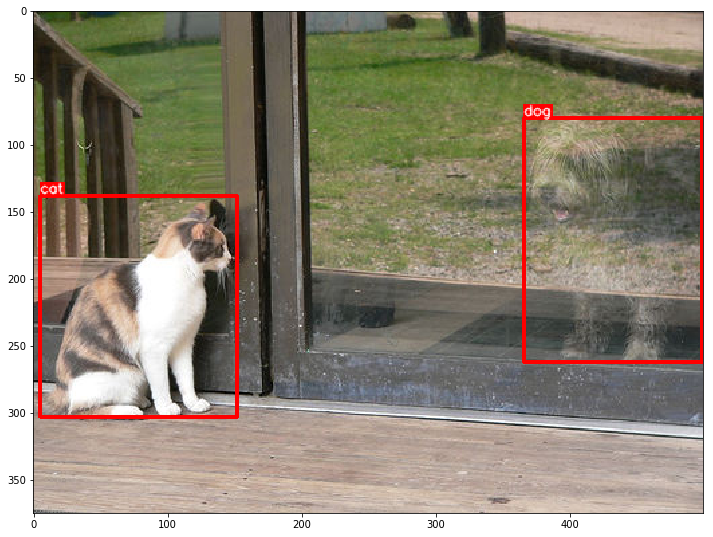

In [28]:
visualize(annotations, category_id_to_name)

## Few simple cases

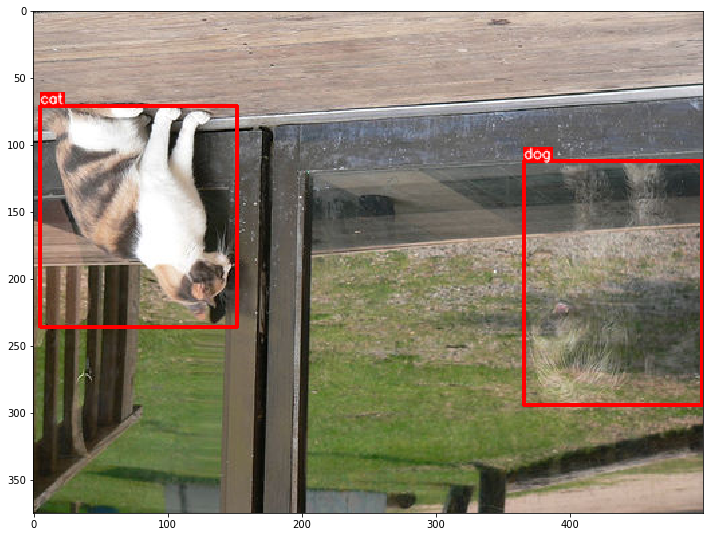

In [29]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

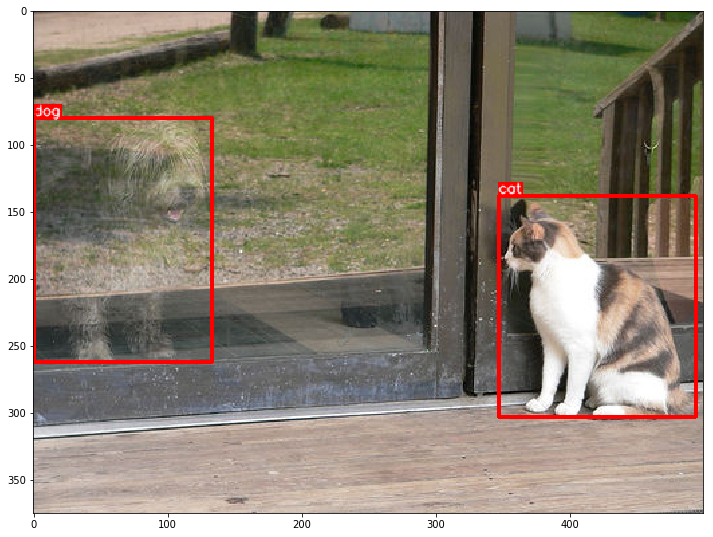

In [30]:
aug = get_aug([HorizontalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

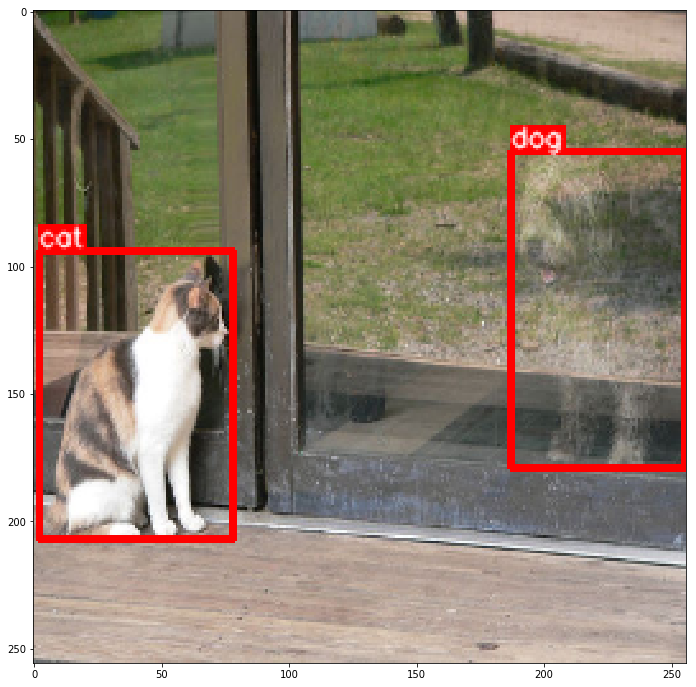

In [31]:
aug = get_aug([Resize(p=1, height=256, width=256)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)


## Some transforms could cut boxes or even delete them. 

You have two options to control this behavior: **min_area** and **min_visibility**

By default **min_area** and **min_visibility** are both zeros, so only boxes outside of picture are going to be deleted



## CenterCrop <span id='center-crop'></span>


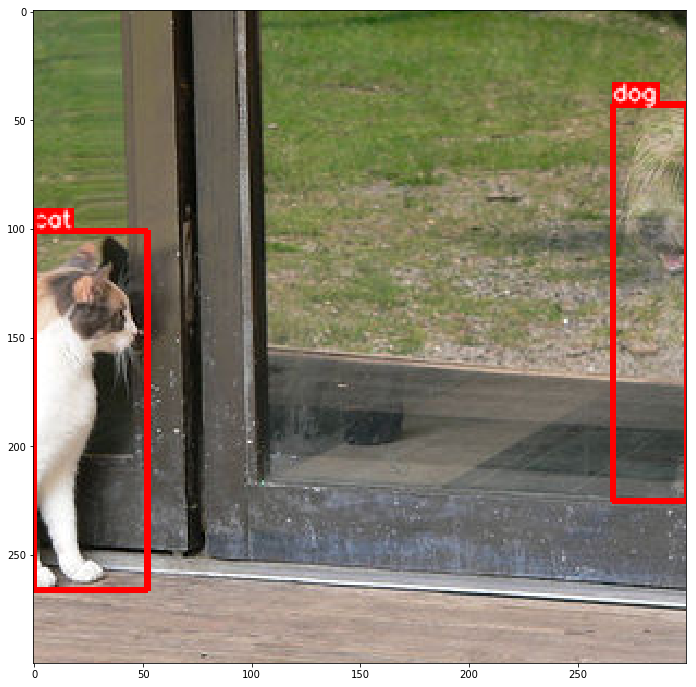

In [32]:
aug = get_aug([CenterCrop(p=1, height=300, width=300)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

## CenterCrop with default filter <span id='center-crop-filter-bboxes'></span>

[17]


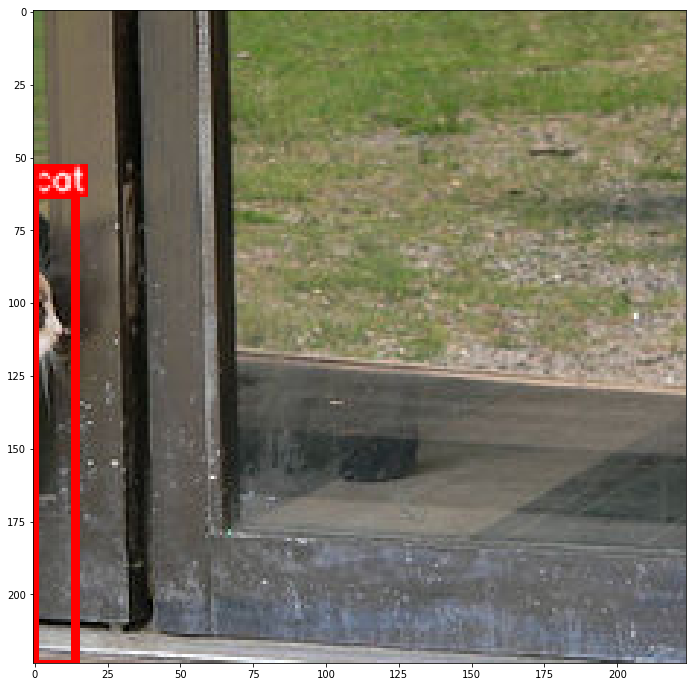

In [33]:
aug = get_aug([CenterCrop(p=1, height=224, width=224)])
augmented = aug(**annotations)
print(augmented['category_id'])
visualize(augmented, category_id_to_name)

## CenterCrop + filter with min_area <span id='center-crop-filter-bboxes-min-area'></span>

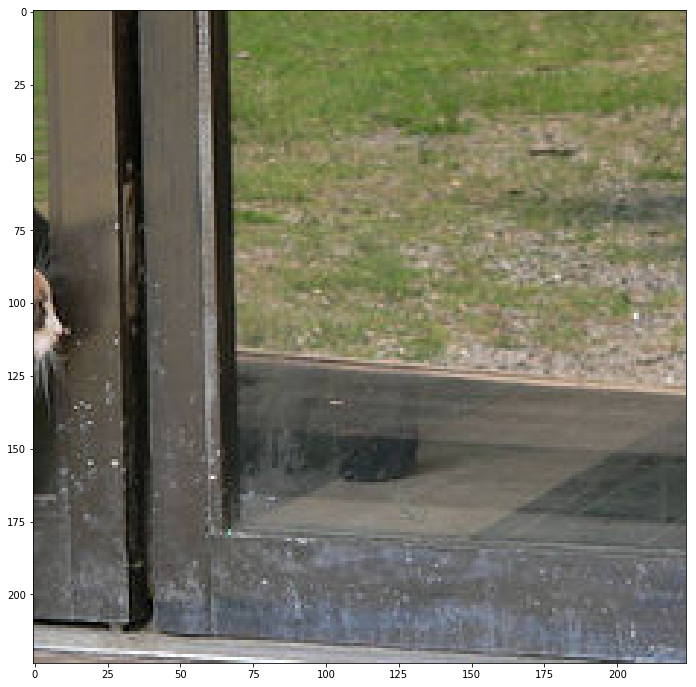

In [34]:
aug = get_aug([CenterCrop(p=1, height=224, width=224)], min_area=4000)
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

## CenterCrop + filter by visibility <span id='filter-bbox-by-visibility'></span>

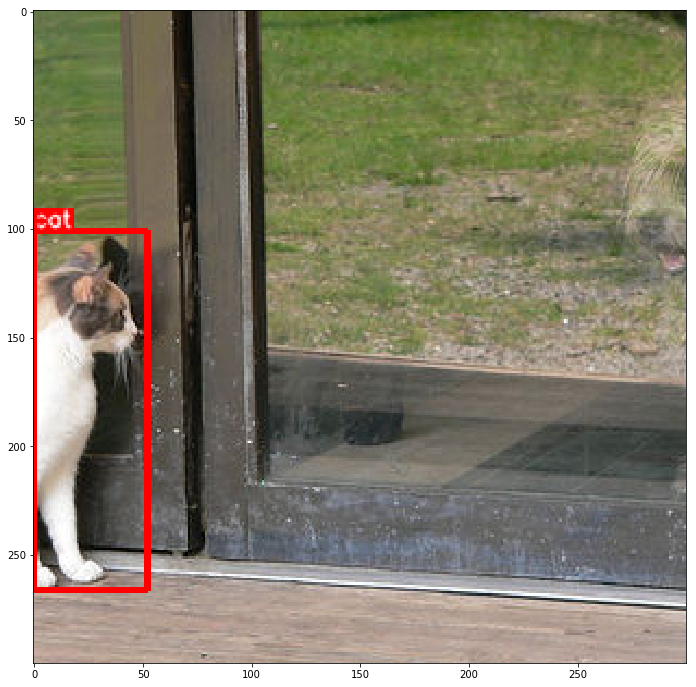

In [37]:
# Compose filters bounding boxes and returns
# only those boxes whose visibility after transformation is above the threshold.
aug = get_aug([CenterCrop(p=1, height=300, width=300)], min_visibility=0.3)
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

# Visibility of the transformed bbox for `dog` is about 0.25 (that means that
# the area of the transformed bbox is about 25% of the area of the original bbox),
# so it will be removed
# Visibility of the transformed bbox for `cat` is about 0.36,
# so it will be kept.